# Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Building a simple CNN model

#### **Task 1: Reading the data**

Importing all the important libraries

In [1]:
!pip install -q ipython-autotime

In [2]:
# Importing the required libraries
import pathlib
import os
import PIL

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

%load_ext autotime

time: 347 µs (started: 2022-10-12 03:02:59 +00:00)


You are expected to load the data in the Colab environment by mounting the Google Drive. This will allow you to access the files from Google drive through Colab. 

Steps:
1. Upload the dataset in your Google Drive in a separate folder. Avoid spaces in the name of the folder or the zip file.
2. Mount the Google Drive using the code given below.
3. Unzip the file to access images.
4. Check the path for the datasets - train and test.


Note: The code is commented for you to learn and then make edits to execute the command.

In [3]:
def download_file_google_drive(id: str, f_name: str, f_save_path: str=""):
    """
    Download file from Google Drive

    Args:
        id (str): Google Drive File ID
        f_name (str): File name
        f_save_path (str): File save path. 
            default: Current working directory
    """
    import os, requests

    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://drive.google.com/uc?export=download&confirm=yTib"

    f_save_path = os.getcwd() if not f_save_path else f_save_path.rstrip("/")
    destination = f"{f_save_path}/{f_name}"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)

download_file_google_drive(id="1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs", 
                           f_name="Skin_Cancer_ISIC.zip", 
                           f_save_path=os.getcwd())


time: 4.6 s (started: 2022-10-12 03:02:59 +00:00)


In [4]:
def run_cmd(cmd, verbose=False, *args, **kwargs) -> None:
    """
    Run system command as a subprocess
    """
    import subprocess

    process = subprocess.Popen(cmd,
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               text=True,
                               shell=True)
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)

time: 1.86 ms (started: 2022-10-12 03:03:03 +00:00)


In [5]:
# Unzipping the files
# To do: Update the folder name and file name

file_name = "Skin_Cancer_ISIC"

run_cmd(f"unzip -q {os.getcwd()}/{file_name}")

time: 65.2 ms (started: 2022-10-12 03:03:03 +00:00)


Check the path mentioned in the output: `Skin cancer ISIC The International Skin Imaging Collaboration`

Provide the path for train and test images using pathlib library.

In [6]:
# Defining the path for train and test images
## To do: Update the paths of the train and test dataset
folder_name = "Skin cancer ISIC The International Skin Imaging Collaboration"
data_path = f"{os.getcwd()}/{folder_name}"
data_dir_train = pathlib.Path(f"{data_path}/Train")
data_dir_test = pathlib.Path(f"{data_path}/Test")

time: 864 µs (started: 2022-10-12 03:03:03 +00:00)


Check whether the data has been extracted successfully.

In [7]:
# Train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118
time: 17.8 ms (started: 2022-10-12 03:03:03 +00:00)


#### **Task 2: Loading the images using keras.preprocessing**

The images are still not loaded in the Colab environment. We have extracted them from the zip file. Now, you are expected to load them in the Colab notebook using the `preprocessing` attribute.

Let's load these images off disk using the helpful image_dataset_from_directory utility. You can refer to the following [link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to know more about the function. You can even refer to the additional notebooks on the page to check how the variables are defined.



Defining the parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

time: 775 µs (started: 2022-10-12 03:03:03 +00:00)


Divide the training set into 2 parts: 
*   80% for training 
*   20% for validation



In [9]:
## Write your code for train dataset here.
## Note: Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Make sure you resize your images to the size: img_height*img_width, while specifying the variable

from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(data_dir_train, 
                                        batch_size=batch_size,
                                        image_size=(img_height, img_width),
                                        validation_split= 0.2,
                                        subset="training",
                                        seed=123)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
time: 1.11 s (started: 2022-10-12 03:03:03 +00:00)


In [10]:
## Write your code for validation dataset here.
## Note: Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: Make sure you resize your images to the size: img_height*img_width, while specifying the variable

val_ds = image_dataset_from_directory(data_dir_train, 
                                      batch_size=batch_size,
                                      image_size=(img_height, img_width),
                                      validation_split= 0.2,
                                      subset="validation",
                                      seed=123)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
time: 238 ms (started: 2022-10-12 03:03:05 +00:00)


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the 'class_names' attribute associated with the training and validation datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
time: 792 µs (started: 2022-10-12 03:03:05 +00:00)


#### **Task 3: Visualize the data**

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Write the code to visualize one instance of all the nine classes present in the dataset

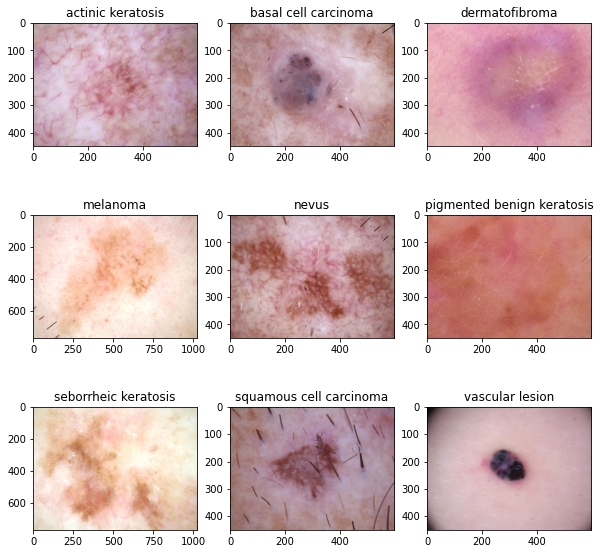

time: 1.57 s (started: 2022-10-12 03:03:05 +00:00)


In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)

#### Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

time: 5.61 ms (started: 2022-10-12 03:03:06 +00:00)


#### **Task 4: Create the model**
Create a CNN model, which can accurately detect 9 classes present in the dataset. 


*   Note: The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`. Use `layers.experimental.preprocessing.Rescaling` for this purpose.

In [14]:
### Your code goes here

from tensorflow.keras.layers import (BatchNormalization,
                                     Dense, 
                                     Dropout, 
                                     Flatten, 
                                     Conv2D, 
                                     MaxPool2D, 
                                     Rescaling)
num_classes = 9

model = Sequential([Rescaling(1./255, input_shape=(img_height, img_width, 3))])

model.add(Conv2D(filters=32, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

time: 96.2 ms (started: 2022-10-12 03:03:06 +00:00)


#### **Question**: 
Explain the following elements associated with the problem:
1.   Selection of stride value (Reason for using a high/low value)
2.   Padding strategy used (Same/Valid)

*For the basic model, we have selected the following*

1. *Stride - We are using the default stride of 1.*
2. *Padding - We are performing `Same` padding so that the layer's outputs will have the same spatial dimensions as its inputs.*

#### **Task 5: Compile the model**
Choose an appropirate optimiser and loss function for model training.

In [15]:
### Choose an appropirate optimiser and loss function
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

time: 12.4 ms (started: 2022-10-12 02:27:30 +00:00)


In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        1

#### Train the model

In [17]:
# The model needs to be trained for 20 epochs
epochs = 20

history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 23s 97ms/step - loss: 3.6464 - accuracy: 0.1920 - val_loss: 2.1781 - val_accuracy: 0.2282
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8324 - accuracy: 0.3237 - val_loss: 2.1755 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6150 - accuracy: 0.4247 - val_loss: 2.1701 - val_accuracy: 0.1745
Epoch 4/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4874 - accuracy: 0.4688 - val_loss: 2.1488 - val_accuracy: 0.2461
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4433 - accuracy: 0.4821 - val_loss: 2.1257 - val_accuracy: 0.2170
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.3891 - accuracy: 0.5045 - val_loss: 2.1157 - val_accuracy: 0.2774
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3608 - accuracy: 0.5123 - val_loss: 2.0358 - val_accuracy: 0.3669
Epoch 8/20
5

#### Visualizing training results

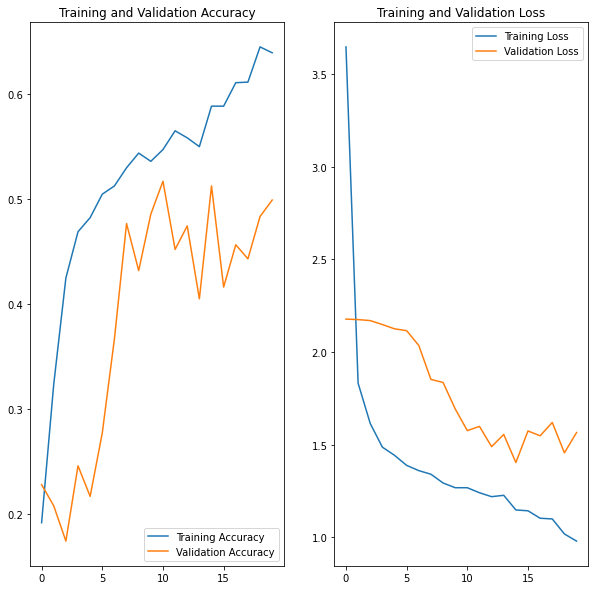

time: 241 ms (started: 2022-10-12 02:29:26 +00:00)


In [18]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

*The basic model we can see has very good training accuracy but the validation accuracy doesn't match the training accuracy. We also note that the validation loss almost plateaus after a some epochs. This is evidence that the model is overfitting.*


## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [19]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = keras.Sequential([RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
                                      RandomRotation(0.1),
                                      RandomZoom(0.1)])

time: 14.4 ms (started: 2022-10-12 02:29:37 +00:00)


Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

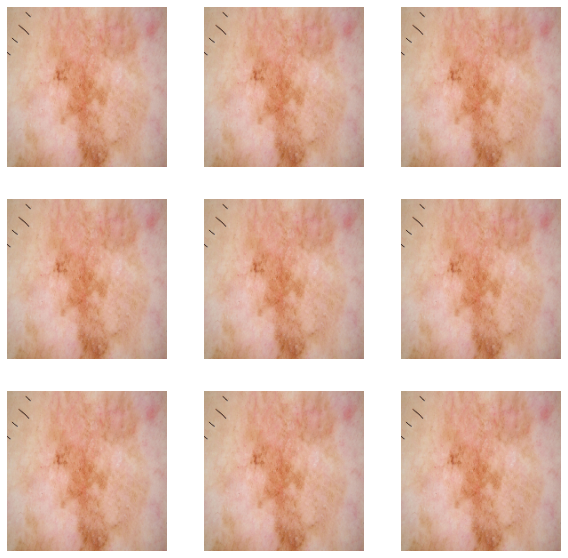

time: 413 ms (started: 2022-10-12 02:29:39 +00:00)


In [20]:
# Visualizing how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### **Task 6: Create, compile and train the model**

Model Definition

In [21]:
## Your code goes here
## You should also include dropouts to tackle with overfitting. (compulsory)

num_classes = 9
model = Sequential([data_augmentation, 
                    Rescaling(1./255, input_shape=(img_height, img_width, 3))])

model.add(Conv2D(filters=32, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(filters=128, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

time: 71.1 ms (started: 2022-10-12 02:29:41 +00:00)


Compiling the model

In [22]:
## Your code goes here

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

time: 6.71 ms (started: 2022-10-12 02:29:41 +00:00)


Training the model

In [23]:
# Note: Train your model for 20 epochs
## Your code goes here

epochs=20
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs)


Epoch 1/20
56/56 [==============================] - 4s 50ms/step - loss: 2.6163 - accuracy: 0.1752 - val_loss: 2.1026 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 46ms/step - loss: 2.0194 - accuracy: 0.2115 - val_loss: 2.0568 - val_accuracy: 0.2215
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9075 - accuracy: 0.2885 - val_loss: 1.8131 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7261 - accuracy: 0.3594 - val_loss: 1.8794 - val_accuracy: 0.2931
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6270 - accuracy: 0.4146 - val_loss: 1.8163 - val_accuracy: 0.3177
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5711 - accuracy: 0.4258 - val_loss: 1.7559 - val_accuracy: 0.3647
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5494 - accuracy: 0.4487 - val_loss: 1.6223 - val_accuracy: 0.4430
Epoch 8/20
56

#### Visualizing the results

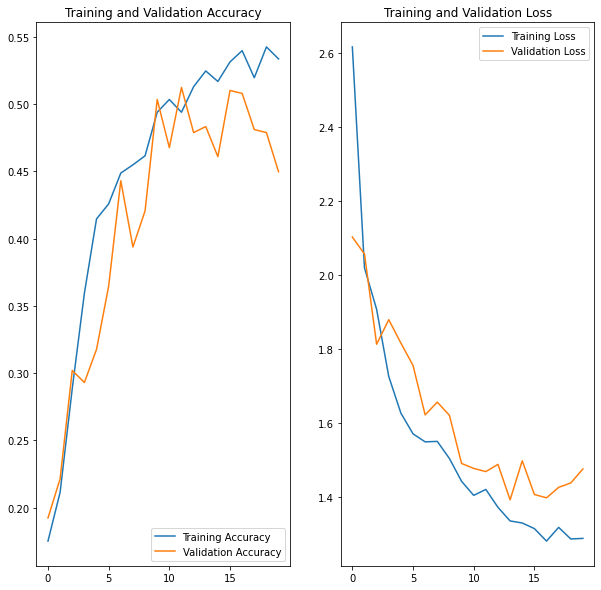

time: 288 ms (started: 2022-10-12 02:30:59 +00:00)


In [24]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We see that adding dropout layers after each CNN unit, helps us reduce overfitting that was seen from the basic model.

## Distribution in the dataset

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<br>

#### **Task 7: Find the distribution of classes in the training dataset.**

In [25]:
## Your code goes here.

path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


time: 30 ms (started: 2022-10-12 02:31:12 +00:00)


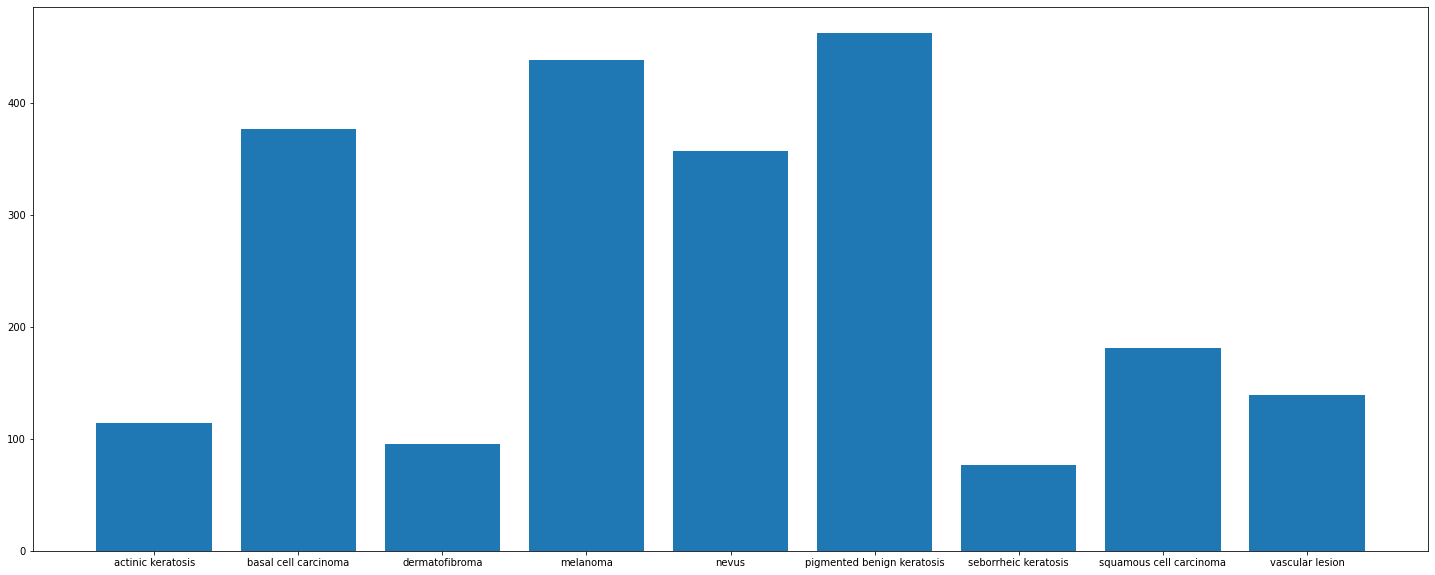

time: 208 ms (started: 2022-10-12 02:31:15 +00:00)


In [26]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

#### **Questions:**  
 - Which class has the least number of samples?
 - Which classes dominate the data in terms proportionate number of samples?


- *The class with the least number of samples is `seborrheic keratosis`.*
- *The classes `melonoma`, `pigmented benign keratosis` and, `basal cell carcinoma` are the dominant in terms of proportionate number of samples.* 



#### **Task 8: Rectifying the class imbalance**
You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install -q Augmentor

time: 3.09 s (started: 2022-10-12 02:31:15 +00:00)


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
# Provide the path for the training dataset
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2B9FEABA90>: 100%|██████████| 500/500 [00:16<00:00, 31.18 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2BA00F2290>: 100%|██████████| 500/500 [00:16<00:00, 31.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C8C2DC450>: 100%|██████████| 500/500 [00:16<00:00, 30.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2BA0147810>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2583x2096 at 0x7F2BA0152ED0>: 100%|██████████| 500/500 [01:23<00:00,  5.97 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2BA00EE150>: 100%|██████████| 500/500 [00:16<00:00, 30.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2BA00F21D0>: 100%|██████████| 500/500 [00:39<00:00, 12.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2BB606A790>: 100%|██████████| 500/500 [00:16<00:00, 29.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2BB614EC10>: 100%|██████████| 500/500 [00:17<00:00, 28.62 Samples/s]

time: 5min 10s (started: 2022-10-12 02:31:19 +00:00)


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [29]:
# Count of images under each class after addition
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500
time: 34.3 ms (started: 2022-10-12 02:36:30 +00:00)


Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_42305178-c6f6-4f73-afc2-d06cd6d5c58c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_44c624d0-c50d-4b7e-adb4-4f33f5cd7f74.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_577348d1-3da2-4834-8518-aacbcacbe15e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_4dc6c3d0-adf3-43bd-a182-d8d270cab146.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_5368ec4f-0dce-4127-b9fe-1f16ae24a533.jpg',
 '/content/Skin

time: 31.3 ms (started: 2022-10-12 02:36:30 +00:00)


In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


time: 65 ms (started: 2022-10-12 02:36:30 +00:00)


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

time: 1.96 ms (started: 2022-10-12 02:36:30 +00:00)


In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

time: 8.08 ms (started: 2022-10-12 02:36:30 +00:00)


In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

time: 13.4 ms (started: 2022-10-12 02:36:30 +00:00)


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Task 9: Repeating the steps for balanced augmented data**

In [35]:
batch_size = 32
img_height = 180
img_width = 180

time: 833 µs (started: 2022-10-12 02:37:02 +00:00)


**Create a training dataset**

In [36]:
# Provide the path here
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Provide the subset value here
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed=123,
                                        validation_split = 0.2,
                                        subset = "training",
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
time: 255 ms (started: 2022-10-12 02:37:08 +00:00)


**Create a validation dataset**

In [37]:
# Provide the subset value here
val_ds = image_dataset_from_directory(data_dir_train,
                                      seed=123,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
time: 237 ms (started: 2022-10-12 02:37:12 +00:00)


**Create your model (make sure to include normalization)**

In [38]:
## Your code goes here
from tensorflow.keras.layers import BatchNormalization

num_classes = 9

model = Sequential([Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(BatchNormalization())

model.add(Conv2D(filters=32, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(filters=128, 
                 kernel_size=(3, 3),
                 padding="Same", 
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

time: 78.4 ms (started: 2022-10-12 02:37:15 +00:00)


In [39]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                      

**Compile your model (Choose optimizer and loss function appropriately)**

In [40]:
## Your code goes here

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


time: 7.35 ms (started: 2022-10-12 02:37:25 +00:00)


**Train your model**

In [41]:
# Note: Train your model for 30 epochs
## Your code goes here

epochs = 30

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs)


Epoch 1/30
169/169 [==============================] - 26s 145ms/step - loss: 3.5252 - accuracy: 0.1307 - val_loss: 2.1926 - val_accuracy: 0.1396
Epoch 2/30
169/169 [==============================] - 24s 140ms/step - loss: 2.0750 - accuracy: 0.1953 - val_loss: 2.0708 - val_accuracy: 0.2643
Epoch 3/30
169/169 [==============================] - 24s 141ms/step - loss: 1.7299 - accuracy: 0.3544 - val_loss: 1.7705 - val_accuracy: 0.3779
Epoch 4/30
169/169 [==============================] - 25s 141ms/step - loss: 1.6392 - accuracy: 0.3961 - val_loss: 1.6472 - val_accuracy: 0.4313
Epoch 5/30
169/169 [==============================] - 25s 142ms/step - loss: 1.5127 - accuracy: 0.4397 - val_loss: 1.4632 - val_accuracy: 0.5167
Epoch 6/30
169/169 [==============================] - 25s 142ms/step - loss: 1.4314 - accuracy: 0.4790 - val_loss: 1.5165 - val_accuracy: 0.4900
Epoch 7/30
169/169 [==============================] - 25s 142ms/step - loss: 1.3087 - accuracy: 0.5211 - val_loss: 1.3809 - val_ac

**Visualize the model results**

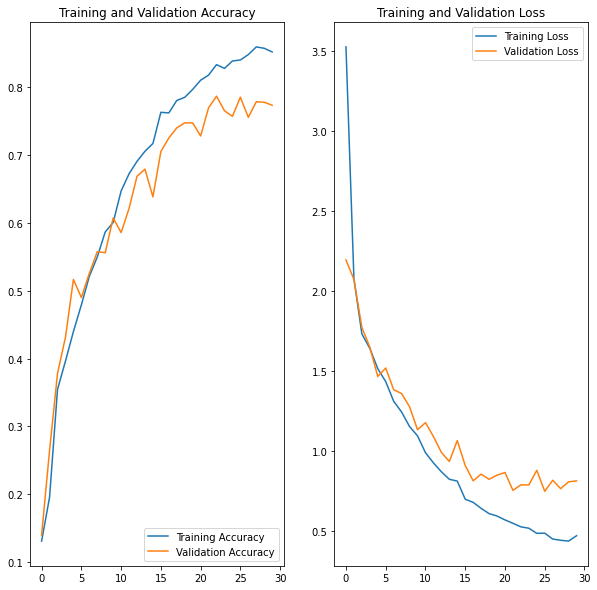

time: 264 ms (started: 2022-10-12 02:54:32 +00:00)


In [42]:
# Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Task 10: Analyzing the results** 


#### **Question:**
- Did you get rid of underfitting/overfitting from the model? 
- Did class rebalance help in the process?


- Dropouts helped to reduce the over fitting issue of the model.
- There was a class imbalance and after class rebalancing model performance improved.